En este notebook, entrenamos modelos de predicción de discursos de odio en base a distintos datasets, para poder predecir su uso en reddit.

Para poder ejecutar este notebook se requiere contar con los conjuntos de datos [HatEval](#Dataset-HatEval-(SemEval-2019-Task5)), [DETOXIS](#Dataset-DETOXIS-(IberLEF-2021)) y [MeOffendMex](#Dataset-MeOffendMex-(Iberlef-2021)) (la información para descargarlos se encuentra en cada uno de los respectivos links). Los datasets descargados deben estar situados respectivamente en las carpetas

    docs/hateval2019/

    docs/detoxis_data/

    docs/MeOffendEs/

In [1]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from prettytable import PrettyTable

from preprocessing_utils import give_emoji_free_text, url_free_text, \
email_free_text, quotes_free_text, get_lemmas, tokenize, preprocess_corpus

nlp = spacy.load("es_core_news_lg")
np.random.seed(42)
palabras_odio = pd.DataFrame(columns=['hateval_rf', 'hateval_nb', 
                                      'detoxis_rf', 'detoxis_nb', 
                                      'meoffendmex_rf', 'meoffendmex_nb'])

## Dataset HatEval (SemEval 2019 Task5)

- Paper: 
    - SemEval-2019 Task 5: Multilingual Detection of Hate Speech Against Immigrants and Women in Twitter, por Basile, Valerio; Bosco, Cristina; Fersini, Elisabetta; Nozza, Debora; Patti, Viviana; Rangel Pardo, Francisco Manuel; Rosso, Paolo; Sanguinetti, Manuela. Proceedings of the 13th International Workshop on Semantic Evaluation. Association for Computational Linguistics, 2019. [URL](https://aclanthology.org/S19-2007/).
- Web: https://competitions.codalab.org/competitions/19935
- Formulario para acceder a los datos: http://hatespeech.di.unito.it/hateval.html

### Descripción

Este dataset consiste en ~7000 Tweets, que posiblemente representen discurso de odio hacia mujeres o inmigrantes.

El dataset está formado por 5 columnas, representando cada una:

1. ID del Tweet.
1. El texto del Tweet.
1. HS (*hate speech*): si el discurso de odio ocurre contra mujeres o inmigrantes.
1. TR (*target*): si HS=1, recibe un valor de 0 si el discurso de odio es contra un grupo genérico, o un valor de 1 si es específicamente contra un individuo.
1. AG (*aggresive*): si HS=1, indica si quien escribe el Tweet exhibe comportamiento agresivo (si es así: 1; en caso contrario: 0).

([fuente](https://competitions.codalab.org/competitions/19935#participate))


In [2]:
verbose = 1
verbose_dataset = 0
verbose_hate_words = 0

In [3]:
# cargamos el dataset y vemos su información

hate_eval = pd.read_csv('docs/hateval2019/hateval2019_es_train.csv')
if verbose_dataset:
    print(hate_eval.describe())

In [4]:
if verbose_dataset:
    print(hate_eval[hate_eval['HS']==1])

In [5]:
print('Cantidad de Tweets sin HS: {} \nCantidad de Tweets con HS: {}'.format(
    len(hate_eval[hate_eval['HS']==0]), len(hate_eval[hate_eval['HS']==1])))

Cantidad de Tweets sin HS: 2643 
Cantidad de Tweets con HS: 1857


## Dataset DETOXIS (IberLEF 2021)

- Web: https://detoxisiberlef.wixsite.com/website/corpus
- Formulario para acceder a los datos: https://forms.office.com/r/6csEeBW0w3

### Descripción

Este es un dataset con cerca de 3500 comentarios de sitios de noticias/foros españoles, que posiblemente contienen toxicidad. El punto distintivo de este dataset es que distingue distintos niveles de toxicidad, desde 0 (no tóxico) hasta 3 (muy tóxico), en donde también están anotados aspectos como el uso de insultos, sarcasmo, agresividad, estereotipación, constructividad, entre otros. En el contexto de este trabajo, se entrenó un modelo en donde se intenta predecir si un comentario es o no agresivo.


In [6]:
# cargamos detoxis dataset

detoxis = pd.read_csv('docs/detoxis_data/train.csv')
if verbose_dataset:
    print(detoxis.describe())

In [56]:
if verbose_dataset:
    print(detoxis[detoxis['aggressiveness']==1])

## Dataset MeOffendES (Iberlef 2021)

- Papers:
    
    * OffendES: A New Corpus in Spanish for Offensive Language Research, por Plaza-del-Arco, Flor Miriam; Montejo Ráez, Arturo; Ureña-López, L. Alfonso y Martín Valdivia, María Teresa. Proceedings of the International Conference on Recent Advances in Natural Language Processing (RANLP 2021). INCOMA Ltd., 2021. [URL](https://aclanthology.org/2021.ranlp-main.123).
    * Overview of MeOffendEs at IberLEF 2021: Offensive Language Detection in Spanish Variants, por Plaza-del-Arco, Flor Miriam; Casavantes, Marco; Escalante, Hugo Jair; Martín Valdivia, María Teresa; Montejo Ráez, Arturo; Montes y Gómez, Manuel; Jarquín-Vásquez, Horacio y Villaseñor Pineda, Luis. Procesamiento del Lenguaje Natural, Revista nº 67, septiembre de 2021, Sociedad Española para el Procesamiento del Lenguaje Natural. [URL](https://rua.ua.es/dspace/handle/10045/117506).

- Web: https://competitions.codalab.org/competitions/28679
- Repositorio: https://github.com/pendrag/MeOffendEs


### Descripción

Este dataset consiste tweets de usuarios tanto de España (MeOffendES) como de México (MeOffendMex, este último con alrededor de 5000 tweets), que posiblemente contienen mensajes ofensivos. En este trabajo, se optó por usar la variante MeOffendMex, ya que se consideró a los mensajes de la misma como los más cercanos al trabajo aquí abordado.

El dataset está formado por  columnas, representando cada una datos como el texto del comentario, y datos de la cuenta de Twitter como por ejemplo si la cuenta se encuentra verificada, el nombre de la cuenta y si la misma tiene una imagen por defecto, entre otros. En este trabajo se optó por usar solamente el texto del tweet. Se cuenta con dos salidas, una indica si el tweet es ofensivo, y la otra si representa "lenguaje vulgar"; se optó por utilizar solamente la primera.


In [8]:
# cargamos MeOffendMex dataset

meoffendmex = pd.read_csv('docs/MeOffendEs/mx-train-data-non-contextual.csv')
y_meoffendmex = pd.read_csv('docs/MeOffendEs/mx-train-outputs.sol', header=None) 

if verbose_dataset:
    print(meoffendmex.describe())

In [9]:
if verbose_dataset:
    print(meoffendmex.head())

# Procesamos y entrenamos cada uno de los datasets

Definimos la función general de entrenamiento, que lee un conjunto de datos, lo vectoriza y entrena un modelo a partir de dicha vectorización, mostrando las métricas generales del mismo.

In [10]:
def process_training_pipeline(dataset, vectorizer, labels, model):
    vectorized_corpus = vectorizer.fit_transform(dataset)
    X_tr, X_val, y_tr, y_val = train_test_split(vectorized_corpus, labels, test_size=0.3, random_state=42)
    model.fit(X_tr, y_tr)

    print('\nMétricas (train)')
    print(classification_report(model.predict(X_tr), y_tr))
    print('Matriz de confusión (train)')
    plot_confusion_matrix(model, X_tr, y_tr,
                          cmap=plt.cm.Blues, 
                          normalize='true')
    plt.show()
    print('\nMétricas (val)')
    print(classification_report(model.predict(X_val), y_val))
    print('Matriz de confusión (val)')
    plot_confusion_matrix(model, X_val, y_val,
                          cmap=plt.cm.Blues, 
                          normalize='true')
    plt.show()
    

### Hateval dataset

In [11]:
hateval_corpus_lines = preprocess_corpus(hate_eval['text'])

In [12]:
y_hateval = hate_eval['HS'].values

In [13]:
cv_hateval = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_hateval = LogisticRegression(random_state=42)
nb_hateval = ComplementNB()
rf_hateval = RandomForestClassifier(random_state=42)


Métricas (train)
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1898
           1       0.89      0.92      0.91      1252

    accuracy                           0.93      3150
   macro avg       0.92      0.93      0.92      3150
weighted avg       0.93      0.93      0.93      3150

Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


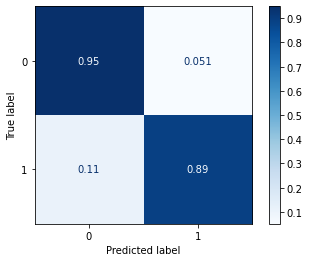


Métricas (val)
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       812
           1       0.75      0.78      0.76       538

    accuracy                           0.81      1350
   macro avg       0.80      0.80      0.80      1350
weighted avg       0.81      0.81      0.81      1350

Matriz de confusión (val)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


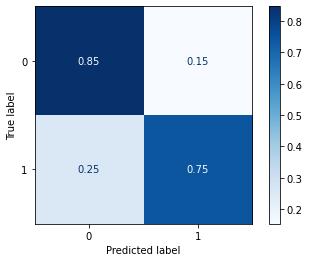

In [14]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          lg_hateval
                         )


Métricas (train)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1851
           1       1.00      1.00      1.00      1299

    accuracy                           1.00      3150
   macro avg       1.00      1.00      1.00      3150
weighted avg       1.00      1.00      1.00      3150

Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


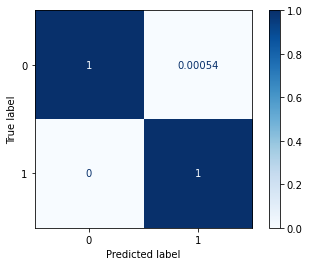

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



Métricas (val)
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       844
           1       0.71      0.79      0.75       506

    accuracy                           0.80      1350
   macro avg       0.79      0.80      0.79      1350
weighted avg       0.81      0.80      0.80      1350

Matriz de confusión (val)


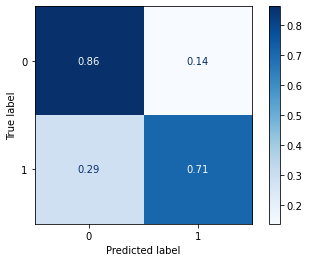

In [15]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          rf_hateval
                         )

In [16]:
if verbose_dataset:
    print(cv_hateval.get_feature_names()[:5])

In [17]:
# obtenemos las características que más aportan a la clasificación del modelo random forest
rf_features_hateval_idx = rf_hateval.feature_importances_.argsort()[::-1]
palabras_odio_rf_hateval = np.array(cv_hateval.get_feature_names())[rf_features_hateval_idx[:100]]
palabras_odio['hateval_rf'] = pd.Series(palabras_odio_rf_hateval)

if verbose_hate_words:
    print(palabras_odio_rf_hateval)
    print(rf_hateval.feature_importances_[rf_features_hateval_idx[:30]])

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



Métricas (train)
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1674
           1       0.87      0.77      0.81      1476

    accuracy                           0.84      3150
   macro avg       0.84      0.83      0.83      3150
weighted avg       0.84      0.84      0.84      3150

Matriz de confusión (train)


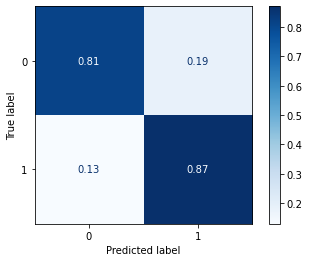


Métricas (val)
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       719
           1       0.79      0.70      0.74       631

    accuracy                           0.77      1350
   macro avg       0.77      0.77      0.77      1350
weighted avg       0.77      0.77      0.77      1350

Matriz de confusión (val)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


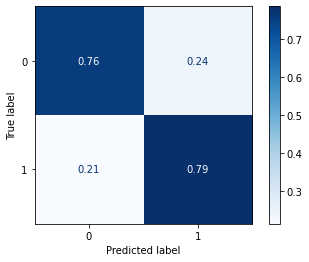

In [18]:
process_training_pipeline(hateval_corpus_lines, 
                          cv_hateval,
                          y_hateval,
                          nb_hateval
                         )

In [19]:
# basado en https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
pos_class_prob_sorted = nb_hateval.feature_log_prob_[1, :].argsort()[::-1]
palabras_odio_nb_hateval = np.take(cv_hateval.get_feature_names(), pos_class_prob_sorted[:100])
palabras_odio['hateval_nb'] = pd.Series(palabras_odio_nb_hateval)

if verbose_hate_words:
    print(palabras_odio_nb_hateval)

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# guardamos el vectorizador y los modelos entrenados

with open('docs/models/hateval_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv_hateval, file)

with open('docs/models/hateval_lg_model.pkl', 'wb') as file:
    pickle.dump(lg_hateval, file)

with open('docs/models/hateval_nb_model.pkl', 'wb') as file:
    pickle.dump(nb_hateval, file)

with open('docs/models/hateval_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_hateval, file)
    

## Detoxis dataset

In [21]:
detoxis_corpus_lines = preprocess_corpus(detoxis['comment'])
y_detoxis = detoxis['aggressiveness']

In [22]:
y_detoxis[detoxis['aggressiveness']==1]

2       1
5       1
10      1
29      1
32      1
       ..
3280    1
3288    1
3289    1
3291    1
3295    1
Name: aggressiveness, Length: 114, dtype: int64

In [23]:
cv_detoxis = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_detoxis = LogisticRegression(random_state=42)
nb_detoxis = ComplementNB()
rf_detoxis = RandomForestClassifier(random_state=42)


Métricas (train)
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2371
           1       0.72      1.00      0.83        53

    accuracy                           0.99      2424
   macro avg       0.86      1.00      0.92      2424
weighted avg       0.99      0.99      0.99      2424

Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


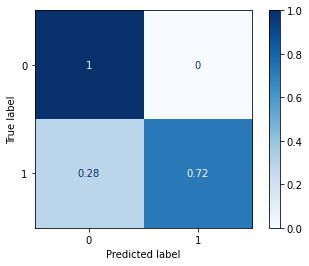


Métricas (val)
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1032
           1       0.05      0.29      0.09         7

    accuracy                           0.96      1039
   macro avg       0.52      0.62      0.53      1039
weighted avg       0.99      0.96      0.97      1039

Matriz de confusión (val)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


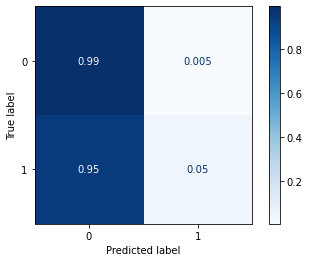

In [24]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          lg_detoxis
                         )


Métricas (train)
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2160
           1       0.85      0.24      0.37       264

    accuracy                           0.91      2424
   macro avg       0.88      0.62      0.66      2424
weighted avg       0.91      0.91      0.89      2424

Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


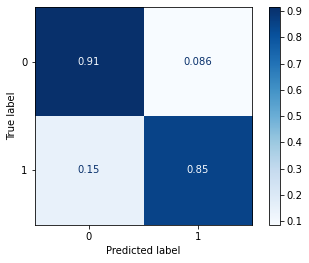


Métricas (val)
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       914
           1       0.23      0.07      0.11       125

    accuracy                           0.86      1039
   macro avg       0.55      0.52      0.52      1039
weighted avg       0.80      0.86      0.83      1039

Matriz de confusión (val)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


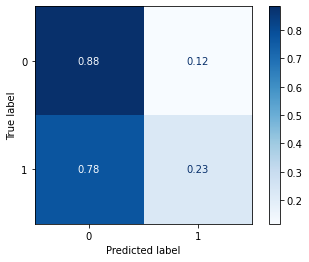

In [25]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          nb_detoxis
                         )

In [26]:
pos_class_prob_sorted = nb_detoxis.feature_log_prob_[1, :].argsort()[::-1]
palabras_odio_nb_detoxis = np.take(cv_detoxis.get_feature_names(), pos_class_prob_sorted[:100])
palabras_odio['detoxis_nb'] = pd.Series(palabras_odio_nb_detoxis)

if verbose_hate_words:
    print(palabras_odio_nb_detoxis)

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Métricas (train)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2351
           1       0.99      1.00      0.99        73

    accuracy                           1.00      2424
   macro avg       0.99      1.00      1.00      2424
weighted avg       1.00      1.00      1.00      2424

Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


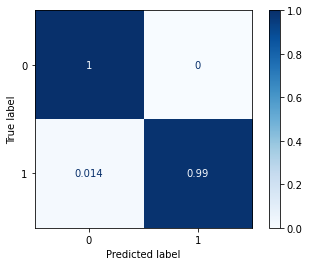


Métricas (val)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1039
           1       0.00      0.00      0.00         0

    accuracy                           0.96      1039
   macro avg       0.50      0.48      0.49      1039
weighted avg       1.00      0.96      0.98      1039

Matriz de confusión (val)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/util

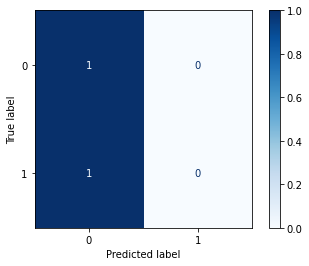

In [27]:
process_training_pipeline(detoxis_corpus_lines, 
                          cv_detoxis,
                          y_detoxis,
                          rf_detoxis
                         )

In [28]:
# obtenemos las características que más aportan a la clasificación del modelo random forest
rf_features_detoxis_idx = rf_detoxis.feature_importances_.argsort()[::-1]
palabras_odio_rf_detoxis = np.array(cv_detoxis.get_feature_names())[rf_features_detoxis_idx[:100]]
palabras_odio['detoxis_rf'] = pd.Series(palabras_odio_rf_detoxis)

if verbose_hate_words:
    print(palabras_odio_rf_detoxis)
    print(rf_detoxis.feature_importances_[rf_features_detoxis_idx[:30]])

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
# guardamos el vectorizador y los modelos entrenados

with open('docs/models/detoxis_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv_detoxis, file)

with open('docs/models/detoxis_lg_model.pkl', 'wb') as file:
    pickle.dump(lg_detoxis, file)

with open('docs/models/detoxis_nb_model.pkl', 'wb') as file:
    pickle.dump(nb_detoxis, file)

with open('docs/models/detoxis_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_detoxis, file)
    

## MeOffendMex dataset

In [30]:
cv_meoffendmex = CountVectorizer(ngram_range=(1, 3), min_df=10)
lg_meoffendmex = LogisticRegression(random_state=42)
nb_meoffendmex = ComplementNB()
rf_meoffendmex = RandomForestClassifier(random_state=42)

In [31]:
meoffendmex_corpus_lines = preprocess_corpus(meoffendmex['tweet:text'])


Métricas (train)
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2814
           1       0.69      0.89      0.78       728

    accuracy                           0.90      3542
   macro avg       0.83      0.90      0.86      3542
weighted avg       0.91      0.90      0.90      3542

Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


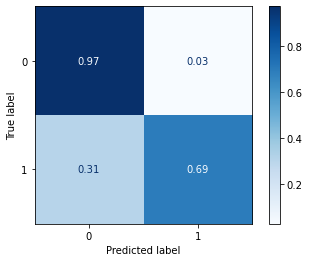


Métricas (val)
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1225
           1       0.44      0.67      0.53       293

    accuracy                           0.77      1518
   macro avg       0.68      0.73      0.69      1518
weighted avg       0.82      0.77      0.79      1518

Matriz de confusión (val)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


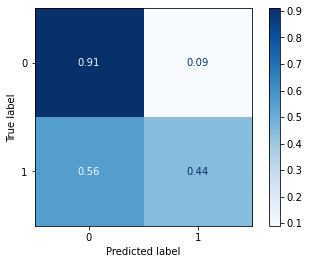

In [32]:
process_training_pipeline(meoffendmex_corpus_lines, 
                          cv_meoffendmex,
                          y_meoffendmex,
                          lg_meoffendmex
                         )

In [33]:
# TODO extracción de palabras de odio con log regression
#cv_meoffendmex


palabras_odio_lg_meoffendmex = []


Métricas (train)
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2243
           1       0.83      0.60      0.69      1299

    accuracy                           0.81      3542
   macro avg       0.81      0.76      0.78      3542
weighted avg       0.81      0.81      0.80      3542

Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


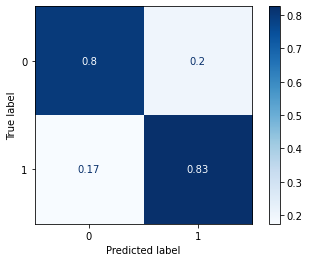


Métricas (val)
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       985
           1       0.69      0.57      0.62       533

    accuracy                           0.76      1518
   macro avg       0.74      0.71      0.72      1518
weighted avg       0.75      0.76      0.75      1518

Matriz de confusión (val)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


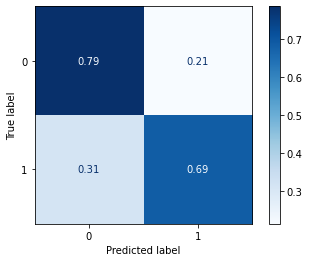

In [34]:
process_training_pipeline(meoffendmex_corpus_lines, 
                          cv_meoffendmex,
                          y_meoffendmex,
                          nb_meoffendmex
                         )

In [35]:
pos_class_prob_sorted = nb_meoffendmex.feature_log_prob_[1, :].argsort()[::-1]
palabras_odio_nb_meoffendmex = np.take(cv_meoffendmex.get_feature_names(), pos_class_prob_sorted[:100])
palabras_odio['meoffendmex_nb'] = pd.Series(palabras_odio_nb_meoffendmex)

if verbose:
    print(palabras_odio_nb_meoffendmex)

['el mundial' 'chilenos' 'por putos' 'prietas' 'como tu' 'mexicanos'
 'argentinos' 'gringos' 'mil putas' 'son unos' 'esperar' 'sabemos'
 'eres un' 'par' 'viernes' 'solo por' 'putito' 'putos hondureños' 'gordo'
 'ver si' 'hijo de tu' 'hondureños' 'la mierda' 'lo peor' 'lameculos'
 'por ser' 'tal vez' 'de sus putas' 'te voy' 'perra' 'tambien' 'te vas'
 'son bien' 'sabía' 'con tus' 'que putos' 'cuándo' 'de este'
 'tienen madre' 'hija de' 'de su puta' 'cago' 'carajo' 'realidad'
 'son putos' 'el joto' 'basura' 'esa golfa' 'el hdp' 'unos putos'
 'sus putas madres' 'siendo' 'trump' 'que feas' 'putos los' 'vieja'
 'viejas' 'los de' 'madre los' 'madre me' 'punto de' 'primero'
 'presidente' 'porno' 'váyanse' 'al mundial' 'pinche gorda' 'ya lo'
 'pienso' 'piensan' 'no sea' 'no tienen madre' 'argentina' 'aparte'
 'que bueno que' 'vete' 'vete la verga' 'vete la' 'azul' 'noerapenal'
 'deja de' 'moral' 'pinche joto' 'el culo' 'pasar' 'ir al' 'que quiero'
 'conozco' 'tantos' 'pela' 'de tu puta' 'polít

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<ipython-input-10-5a0831644151>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_tr, y_tr)



Métricas (train)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2604
           1       1.00      1.00      1.00       938

    accuracy                           1.00      3542
   macro avg       1.00      1.00      1.00      3542
weighted avg       1.00      1.00      1.00      3542

Matriz de confusión (train)


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


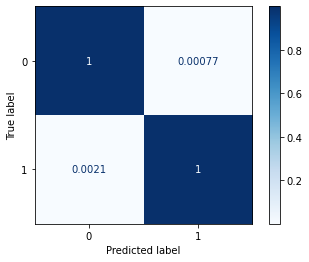

/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



Métricas (val)
              precision    recall  f1-score   support

           0       0.95      0.79      0.87      1291
           1       0.40      0.78      0.53       227

    accuracy                           0.79      1518
   macro avg       0.67      0.78      0.70      1518
weighted avg       0.87      0.79      0.81      1518

Matriz de confusión (val)


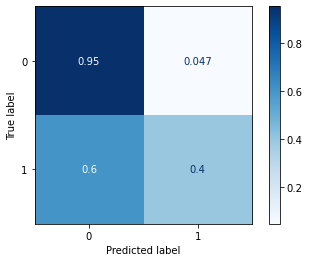

In [36]:
process_training_pipeline(meoffendmex_corpus_lines, 
                          cv_meoffendmex,
                          y_meoffendmex,
                          rf_meoffendmex
                         )

In [37]:
# obtenemos las características que más aportan a la clasificación del modelo random forest
rf_features_meoffendmex_idx = rf_meoffendmex.feature_importances_.argsort()[::-1]
palabras_odio_rf_meoffendmex = np.array(cv_meoffendmex.get_feature_names())[rf_features_meoffendmex_idx[:100]]
palabras_odio['meoffendmex_rf'] = pd.Series(palabras_odio_rf_meoffendmex)

if verbose:
    print(palabras_odio_rf_meoffendmex)

['hdp' 'pinche' 'tu' 'que' 'de' 'maricon' 'putos' 'la' 'me' 'joto' 'no'
 'son' 'el' 'en' 'pendejo' 'tu madre' 'los' 'se' 'hijo de' 'madre' 'loca'
 'es' 'por' 'pinches' 'te' 'ya' 'las' 'lo' 'hijo' 'un' 'verga' 'con'
 'para' 'vieja' 'golfa' 'prieta' 'lameculos' 'una' 'putas' 'su' 'mi'
 'como' 'eres' 'si' 'perra' 'pero' 'maricón' 'marica' 'la gorda' 'puto'
 'pendejos' 'puta' 'estoy' 'esta' 'gorda' 'de la' 'mundial' 'vete'
 'mierda' 'bien' 'más' 'hijos de' 'de mierda' 'le' 'del' 'pendeja' 'al'
 'les' 'yo' 'vas' 'prietas' 'jajajaja' 'hijos' 'solo' 'gordas'
 'hondureños' 'jajaja' 'él' 'chingar' 'cuando' 'todos' 'mil putas' 'ser'
 'trump' 'feas' 'ojalá' 'tu puta' 'qué' 'chilenos' 'tus' 'putita' 'viejas'
 'que no' 'porque' 'ni' 'culo' 'mujeres' 'chingas tu' 'que se' 'está']


/home/juan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
# guardamos los modelos entrenados

with open('docs/models/meoffendmex_vectorizer.pkl', 'wb') as file:
    pickle.dump(cv_meoffendmex, file)

with open('docs/models/meoffendmex_lg_model.pkl', 'wb') as file:
    pickle.dump(lg_meoffendmex, file)

with open('docs/models/meoffendmex_nb_model.pkl', 'wb') as file:
    pickle.dump(nb_meoffendmex, file)

with open('docs/models/meoffendmex_rf_model.pkl', 'wb') as file:
    pickle.dump(rf_meoffendmex, file)
    

### Guardamos las palabras de odio

In [39]:
palabras_odio.to_csv('docs/palabras_odio.csv')

# Prueba de modelos en Reddit

In [40]:
df = pd.read_csv('docs/preprocessing_reddit_data.csv')

if verbose_dataset:
    print(df)

In [41]:
df_reddit_original = pd.read_csv('docs/preprocessing_reddit_data.csv')

In [42]:
reddit_corpus = preprocess_corpus(df['body'].astype('str'))

En base a los modelos previamente entrenados, usamos la siguiente función para detectar los comentarios de Reddit.

In [43]:
def predict_n_report_on_reddit_comments(cv_model_pairs):
    table = PrettyTable()
    thresholds = np.linspace(0.5, 0.9, 5)
    
    table.field_names = ['Modelo', 
                         'Dataset', 
                         *['# pred. umb. {}'.format(i) for i in thresholds]]
    
    for pair in cv_model_pairs:
        cv = pair[0][0]
        dataset_name = pair[0][1]
        model = pair[1][0]
        model_name = pair[1][1]
        predicted_by_thresh = []
        
        for thresh in thresholds:
            reddit_adapted = cv.transform(reddit_corpus)
            reddit_hs_proba = model.predict_proba(reddit_adapted)[:,1]
            hate_mask = reddit_hs_proba >= thresh
            predicted_by_thresh.append(np.shape(df_reddit_original[hate_mask])[0])
        
        table.add_row([model_name, dataset_name, *predicted_by_thresh])
        
    return table

In [44]:
def predict_n_save_on_reddit_comments(cv, model, threshold, output_file_name):
    reddit_adapted = cv.transform(reddit_corpus)
    reddit_hs_proba = model.predict_proba(reddit_adapted)[:,1]
    hate_mask = reddit_hs_proba >= threshold
    print('Detectados {} comentarios de un total de {}'.format(np.shape(df_reddit_original[hate_mask])[0], np.shape(df_reddit_original)[0]))
    df_reddit_original[hate_mask].to_csv('docs/{}_hate.csv'.format(output_file_name))
    df_reddit_original[~hate_mask].to_csv('docs/{}_non_hate.csv'.format(output_file_name))

## Vemos la cantidad de predicciones en todos los modelos

In [45]:
cv_dataset_pairs = [(cv_hateval, 'HatEval'), (cv_detoxis, 'DETOXIS'), (cv_meoffendmex, 'MeOffendMex')]

cv_model_pairs = [
        [cv_dataset_pairs[0], (lg_hateval, 'Regresión logística')],
        [cv_dataset_pairs[0], (nb_hateval, 'Naive Bayes')],
        [cv_dataset_pairs[0], (rf_hateval, 'Random forest')],
        [cv_dataset_pairs[1], (lg_detoxis, 'Regresión logística')],
        [cv_dataset_pairs[1], (nb_detoxis, 'Naive Bayes')],
        [cv_dataset_pairs[1], (rf_detoxis, 'Random forest')],
        [cv_dataset_pairs[2], (lg_meoffendmex, 'Regresión logística')],
        [cv_dataset_pairs[2], (nb_meoffendmex, 'Naive Bayes')],
        [cv_dataset_pairs[2], (rf_meoffendmex, 'Random forest')],
       ]

predict_n_report_on_reddit_comments(cv_model_pairs)

+---------------------+-------------+------------------+------------------+------------------+------------------+------------------+
|        Modelo       |   Dataset   | # pred. umb. 0.5 | # pred. umb. 0.6 | # pred. umb. 0.7 | # pred. umb. 0.8 | # pred. umb. 0.9 |
+---------------------+-------------+------------------+------------------+------------------+------------------+------------------+
| Regresión logística |   HatEval   |       5344       |       3151       |       1710       |       790        |       227        |
|     Naive Bayes     |   HatEval   |      10420       |       6951       |       4312       |       2370       |       948        |
|    Random forest    |   HatEval   |       1336       |       338        |        52        |        3         |        0         |
| Regresión logística |   DETOXIS   |        19        |        7         |        2         |        0         |        0         |
|     Naive Bayes     |   DETOXIS   |       3695       |       2393       |       1618       |       1003       |       512        |
|    Random forest    |   DETOXIS   |        0         |        0         |        0         |        0         |        0         |
| Regresión logística | MeOffendMex |       1197       |       679        |       367        |       166        |        50        |
|     Naive Bayes     | MeOffendMex |       7977       |       5247       |       3502       |       2075       |       1080       |
|    Random forest    | MeOffendMex |       455        |       167        |        72        |        14        |        0         |
+---------------------+-------------+------------------+------------------+------------------+------------------+------------------+

## Guardamos algunas predicciones para visualizar los CSV generados

### A partir de modelos entrenados con HatEval

In [46]:
predict_n_save_on_reddit_comments(cv_hateval, lg_hateval, 0.8, 'test/test_reddit_hateval_lg_hate_comments')

Detectados 790 comentarios de un total de 27791


In [47]:
predict_n_save_on_reddit_comments(cv_hateval, nb_hateval, 0.8, 'test/test_reddit_hateval_nb_hate_comments')

Detectados 2370 comentarios de un total de 27791


In [48]:
predict_n_save_on_reddit_comments(cv_hateval, rf_hateval, 0.7, 'test/test_reddit_hateval_rf_hate_comments')

Detectados 52 comentarios de un total de 27791


### A partir de modelos entrenados con Detoxis

In [49]:
predict_n_save_on_reddit_comments(cv_detoxis, lg_detoxis, 0.5, 'test/test_reddit_detoxis_lg_hate_comments')

Detectados 19 comentarios de un total de 27791


In [50]:
predict_n_save_on_reddit_comments(cv_detoxis, nb_detoxis, 0.8, 'test/test_reddit_detoxis_nb_hate_comments')

Detectados 1003 comentarios de un total de 27791


In [51]:
predict_n_save_on_reddit_comments(cv_detoxis, rf_detoxis, 0.5, 'test/test_reddit_detoxis_rf_hate_comments')

Detectados 0 comentarios de un total de 27791


### A partir de modelos entrenados con MeOffendMex

In [52]:
predict_n_save_on_reddit_comments(cv_meoffendmex, lg_meoffendmex, 0.8, 'test/test_reddit_meoffendmex_lg_hate_comments')

Detectados 166 comentarios de un total de 27791


In [53]:
predict_n_save_on_reddit_comments(cv_meoffendmex, nb_meoffendmex, 0.8, 'test/test_reddit_meoffendmex_nb_hate_comments')

Detectados 2075 comentarios de un total de 27791


In [54]:
predict_n_save_on_reddit_comments(cv_meoffendmex, rf_meoffendmex, 0.5, 'test/test_reddit_meoffendmex_rf_hate_comments')

Detectados 455 comentarios de un total de 27791


# Mejoras a realizar

En este notebook se utilizaron modelos en su versión más básica. Como trabajos futuros, quedan mejores pendientes, que incluyen realizar una mejora iterativa de cada uno de los modelos empleados, incluir otros, realizar optimización de híper-parámetros, y tomar distintas etiquetas o información (por ejemplo, usar una etiqueta alternativa en DETOXIS), entre otras.

FIN